In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
pd.options.display.width = 0

from IPython.display import display
from PIL import Image

In [2]:
# Load datasets
train_df = pd.read_excel("../Titanic_EDA/titanic/train_fix.xlsx")
test_df = pd.read_csv("test.csv")

# Save PassengerId for submission later
test_passenger_ids = test_df["PassengerId"]

# Add a 'Survived' column to test with NaN values (to keep it together with train)
test_df["Survived"] = None

# Concatenate train and test for processing
combined_df = pd.concat([train_df, test_df], ignore_index=True)

In [3]:
# Convert 'Sex' column: 'male' -> 1, 'female' -> 0
combined_df['Sex'] = combined_df['Sex'].map({'male': 1, 'female': 0}).astype('int32')

In [4]:
combined_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Boarding,Fare,Cabin,Embarked,Name
0,1,0,3,1,22.0,1,0,A/5,21171,7.2500,NaN,S,NaN
1,2,1,1,0,38.0,1,0,PC,17599,71.2833,C85,C,NaN
2,3,1,3,0,26.0,0,0,STON/O2.,3101282,7.9250,NaN,S,NaN
3,4,1,1,0,35.0,1,0,NaN,113803,53.1000,C123,S,NaN
4,5,0,3,1,35.0,0,0,NaN,373450,8.0500,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,None,3,1,NaN,0,0,A.5. 3236,NaN,8.0500,NaN,S,"Spector, Mr. Woolf"
1305,1306,None,1,0,39.0,0,0,PC 17758,NaN,108.9000,C105,C,"Oliva y Ocana, Dona. Fermina"
1306,1307,None,3,1,38.5,0,0,SOTON/O.Q. 3101262,NaN,7.2500,NaN,S,"Saether, Mr. Simon Sivertsen"
1307,1308,None,3,1,NaN,0,0,359309,NaN,8.0500,NaN,S,"Ware, Mr. Frederick"


In [5]:
#Features to use to computate missing age values.
features = ['Sex', 'Pclass', 'Parch', 'SibSp']

# Split the data into observed and missing Age.
train_obs = combined_df[combined_df['Age'].notnull()]
train_missing = combined_df[combined_df['Age'].isnull()]

# Fit the model on rows with observed Age.
X_train = train_obs[features]
y_train = train_obs['Age']
lr = LinearRegression().fit(X_train, y_train)

# Predict Age for missing entries.
X_missing = train_missing[features]
predicted_age = lr.predict(X_missing)

# add noise to reflect uncertainty.
sigma = np.std(y_train - lr.predict(X_train))
predicted_age_noisy = predicted_age + np.random.normal(0, sigma, size=predicted_age.shape)

# Impute the missing Age values.
combined_df.loc[combined_df['Age'].isnull(), 'Age'] = predicted_age_noisy

In [6]:
# Extract the first letter of the Cabin column (deck identifier)
combined_df['Deck'] = combined_df['Cabin'].str[0]

# Impute missing Deck values with the most common Deck per Pclass
combined_df['Deck'] = combined_df.groupby('Pclass')['Deck'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'U'))


In [7]:
combined_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Boarding,Fare,Cabin,Embarked,Name,Deck
0,1,0,3,1,22.000000,1,0,A/5,21171,7.2500,NaN,S,NaN,F
1,2,1,1,0,38.000000,1,0,PC,17599,71.2833,C85,C,NaN,C
2,3,1,3,0,26.000000,0,0,STON/O2.,3101282,7.9250,NaN,S,NaN,F
3,4,1,1,0,35.000000,1,0,NaN,113803,53.1000,C123,S,NaN,C
4,5,0,3,1,35.000000,0,0,NaN,373450,8.0500,NaN,S,NaN,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,None,3,1,20.239807,0,0,A.5. 3236,NaN,8.0500,NaN,S,"Spector, Mr. Woolf",F
1305,1306,None,1,0,39.000000,0,0,PC 17758,NaN,108.9000,C105,C,"Oliva y Ocana, Dona. Fermina",C
1306,1307,None,3,1,38.500000,0,0,SOTON/O.Q. 3101262,NaN,7.2500,NaN,S,"Saether, Mr. Simon Sivertsen",F
1307,1308,None,3,1,25.595577,0,0,359309,NaN,8.0500,NaN,S,"Ware, Mr. Frederick",F


In [8]:
train_encoded = pd.get_dummies(combined_df['Deck'], dtype=int)
train_encoded = train_encoded.rename(columns={'A': 'Deck-A', 'B': 'Deck-B',  'C': 'Deck-C', 'D': 'Deck-D', 'E': 'Deck-E', 'F': 'Deck-F',  'G': 'Deck-G', 'T': 'Deck-T'})

In [9]:
# Extract the first letter of the Embarked column
combined_df['Embarked'] = combined_df['Embarked'].str[0]

# Impute missing Embarked values with the most common per Pclass
combined_df['Embarked'] = combined_df.groupby('Pclass')['Embarked'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'U'))

In [10]:
train_embarked = pd.get_dummies(combined_df['Embarked'], dtype=int)
train_embarked = train_embarked.rename(columns={'C': 'Embarked-C', 'Q': 'Embarked-Q',  'S': 'Embarked-S'})

In [11]:
combined_df = combined_df.copy()
combined_df[['Deck-A', 'Deck-B', 'Deck-C', 'Deck-D', 'Deck-E', 'Deck-F', 'Deck-G', 'Deck-T']] = train_encoded[['Deck-A', 'Deck-B', 'Deck-C', 'Deck-D', 'Deck-E', 'Deck-F', 'Deck-G', 'Deck-T']]

In [12]:
combined_df = combined_df.copy()
combined_df[['Embarked-C', 'Embarked-Q', 'Embarked-S']] = train_embarked[['Embarked-C', 'Embarked-Q', 'Embarked-S']]

In [13]:
train_combined = pd.concat([train_embarked[['Embarked-C', 'Embarked-Q', 'Embarked-S']], 
                            train_encoded[['Deck-A', 'Deck-B', 'Deck-C', 'Deck-D', 'Deck-E', 'Deck-F', 'Deck-G', 'Deck-T']]], 
                           axis=1)

In [14]:
train_final = pd.concat([combined_df, train_combined], axis=1)
train_final

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Boarding,Fare,...,Embarked-Q,Embarked-S,Deck-A,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-T
0,1,0,3,1,22.000000,1,0,A/5,21171,7.2500,...,0,1,0,0,0,0,0,1,0,0
1,2,1,1,0,38.000000,1,0,PC,17599,71.2833,...,0,0,0,0,1,0,0,0,0,0
2,3,1,3,0,26.000000,0,0,STON/O2.,3101282,7.9250,...,0,1,0,0,0,0,0,1,0,0
3,4,1,1,0,35.000000,1,0,NaN,113803,53.1000,...,0,1,0,0,1,0,0,0,0,0
4,5,0,3,1,35.000000,0,0,NaN,373450,8.0500,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,None,3,1,20.239807,0,0,A.5. 3236,NaN,8.0500,...,0,1,0,0,0,0,0,1,0,0
1305,1306,None,1,0,39.000000,0,0,PC 17758,NaN,108.9000,...,0,0,0,0,1,0,0,0,0,0
1306,1307,None,3,1,38.500000,0,0,SOTON/O.Q. 3101262,NaN,7.2500,...,0,1,0,0,0,0,0,1,0,0
1307,1308,None,3,1,25.595577,0,0,359309,NaN,8.0500,...,0,1,0,0,0,0,0,1,0,0


In [15]:
train_final = train_final.loc[:, ~train_final.columns.duplicated()]


In [16]:
train_final

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Boarding,Fare,...,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-T,Embarked-C,Embarked-Q,Embarked-S
0,1,0,3,1,22.000000,1,0,A/5,21171,7.2500,...,0,0,0,0,1,0,0,0,0,1
1,2,1,1,0,38.000000,1,0,PC,17599,71.2833,...,0,1,0,0,0,0,0,1,0,0
2,3,1,3,0,26.000000,0,0,STON/O2.,3101282,7.9250,...,0,0,0,0,1,0,0,0,0,1
3,4,1,1,0,35.000000,1,0,NaN,113803,53.1000,...,0,1,0,0,0,0,0,0,0,1
4,5,0,3,1,35.000000,0,0,NaN,373450,8.0500,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,None,3,1,20.239807,0,0,A.5. 3236,NaN,8.0500,...,0,0,0,0,1,0,0,0,0,1
1305,1306,None,1,0,39.000000,0,0,PC 17758,NaN,108.9000,...,0,1,0,0,0,0,0,1,0,0
1306,1307,None,3,1,38.500000,0,0,SOTON/O.Q. 3101262,NaN,7.2500,...,0,0,0,0,1,0,0,0,0,1
1307,1308,None,3,1,25.595577,0,0,359309,NaN,8.0500,...,0,0,0,0,1,0,0,0,0,1


In [17]:
train_final['Boarding'] = pd.to_numeric(train_final['Boarding'], errors='coerce')  # Convert to numeric
train_final['Boarding'].fillna(train_final['Boarding'].median(), inplace=True)  # Fill missing values

C:\Users\Scott\AppData\Local\Temp\ipykernel_8896\1307204763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final['Boarding'] = pd.to_numeric(train_final['Boarding'], errors='coerce')  # Convert to numeric
C:\Users\Scott\AppData\Local\Temp\ipykernel_8896\1307204763.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operat

### Train a Random Forest Classifier and plot the feature importances.

In [18]:
combined_df = train_final

In [19]:
combined_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Boarding,Fare,...,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-T,Embarked-C,Embarked-Q,Embarked-S
0,1,0,3,1,22.000000,1,0,A/5,21171.0,7.2500,...,0,0,0,0,1,0,0,0,0,1
1,2,1,1,0,38.000000,1,0,PC,17599.0,71.2833,...,0,1,0,0,0,0,0,1,0,0
2,3,1,3,0,26.000000,0,0,STON/O2.,3101282.0,7.9250,...,0,0,0,0,1,0,0,0,0,1
3,4,1,1,0,35.000000,1,0,NaN,113803.0,53.1000,...,0,1,0,0,0,0,0,0,0,1
4,5,0,3,1,35.000000,0,0,NaN,373450.0,8.0500,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,None,3,1,20.239807,0,0,A.5. 3236,37671.0,8.0500,...,0,0,0,0,1,0,0,0,0,1
1305,1306,None,1,0,39.000000,0,0,PC 17758,37671.0,108.9000,...,0,1,0,0,0,0,0,1,0,0
1306,1307,None,3,1,38.500000,0,0,SOTON/O.Q. 3101262,37671.0,7.2500,...,0,0,0,0,1,0,0,0,0,1
1307,1308,None,3,1,25.595577,0,0,359309,37671.0,8.0500,...,0,0,0,0,1,0,0,0,0,1


In [20]:
combined_df = combined_df.drop(['Ticket','Name', 'Cabin', 'Embarked', 'Deck'], axis=1)
combined_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Boarding,Fare,Deck-A,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-T,Embarked-C,Embarked-Q,Embarked-S
0,1,0,3,1,22.000000,1,0,21171.0,7.2500,0,0,0,0,0,1,0,0,0,0,1
1,2,1,1,0,38.000000,1,0,17599.0,71.2833,0,0,1,0,0,0,0,0,1,0,0
2,3,1,3,0,26.000000,0,0,3101282.0,7.9250,0,0,0,0,0,1,0,0,0,0,1
3,4,1,1,0,35.000000,1,0,113803.0,53.1000,0,0,1,0,0,0,0,0,0,0,1
4,5,0,3,1,35.000000,0,0,373450.0,8.0500,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,None,3,1,20.239807,0,0,37671.0,8.0500,0,0,0,0,0,1,0,0,0,0,1
1305,1306,None,1,0,39.000000,0,0,37671.0,108.9000,0,0,1,0,0,0,0,0,1,0,0
1306,1307,None,3,1,38.500000,0,0,37671.0,7.2500,0,0,0,0,0,1,0,0,0,0,1
1307,1308,None,3,1,25.595577,0,0,37671.0,8.0500,0,0,0,0,0,1,0,0,0,0,1


In [21]:
# Split train and test first (BEFORE dropping NaNs)
train_final = combined_df[combined_df["Survived"].notna()].copy()
test_final = combined_df[combined_df["Survived"].isna()].copy()
test_final

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Boarding,Fare,Deck-A,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-T,Embarked-C,Embarked-Q,Embarked-S
891,892,None,3,1,34.500000,0,0,37671.0,7.8292,0,0,0,0,0,1,0,0,0,1,0
892,893,None,3,0,47.000000,1,0,37671.0,7.0000,0,0,0,0,0,1,0,0,0,0,1
893,894,None,2,1,62.000000,0,0,37671.0,9.6875,0,0,0,0,0,1,0,0,0,1,0
894,895,None,3,1,27.000000,0,0,37671.0,8.6625,0,0,0,0,0,1,0,0,0,0,1
895,896,None,3,0,22.000000,1,1,37671.0,12.2875,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,None,3,1,20.239807,0,0,37671.0,8.0500,0,0,0,0,0,1,0,0,0,0,1
1305,1306,None,1,0,39.000000,0,0,37671.0,108.9000,0,0,1,0,0,0,0,0,1,0,0
1306,1307,None,3,1,38.500000,0,0,37671.0,7.2500,0,0,0,0,0,1,0,0,0,0,1
1307,1308,None,3,1,25.595577,0,0,37671.0,8.0500,0,0,0,0,0,1,0,0,0,0,1


In [22]:
combined_df.dropna(inplace=True)
combined_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Boarding,Fare,Deck-A,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-T,Embarked-C,Embarked-Q,Embarked-S
0,1,0,3,1,22.000000,1,0,21171.0,7.2500,0,0,0,0,0,1,0,0,0,0,1
1,2,1,1,0,38.000000,1,0,17599.0,71.2833,0,0,1,0,0,0,0,0,1,0,0
2,3,1,3,0,26.000000,0,0,3101282.0,7.9250,0,0,0,0,0,1,0,0,0,0,1
3,4,1,1,0,35.000000,1,0,113803.0,53.1000,0,0,1,0,0,0,0,0,0,0,1
4,5,0,3,1,35.000000,0,0,373450.0,8.0500,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.000000,0,0,211536.0,13.0000,0,0,0,0,0,1,0,0,0,0,1
887,888,1,1,0,19.000000,0,0,112053.0,30.0000,0,1,0,0,0,0,0,0,0,0,1
888,889,0,3,0,-0.649205,1,2,6607.0,23.4500,0,0,0,0,0,1,0,0,0,0,1
889,890,1,1,1,26.000000,0,0,111369.0,30.0000,0,0,1,0,0,0,0,0,1,0,0


In [23]:
# Drop 'Survived' from test set since it's unknown
test_final = test_final.drop(columns=["Survived"])

In [26]:
train_final["Survived"] = train_final["Survived"].astype(int)  # Ensure integer values
train_final = train_final.dropna(subset=["Survived"])  # Drop rows with NaN in 'Survived'


In [27]:
test_final

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Boarding,Fare,Deck-A,Deck-B,Deck-C,Deck-D,Deck-E,Deck-F,Deck-G,Deck-T,Embarked-C,Embarked-Q,Embarked-S
891,892,3,1,34.500000,0,0,37671.0,7.8292,0,0,0,0,0,1,0,0,0,1,0
892,893,3,0,47.000000,1,0,37671.0,7.0000,0,0,0,0,0,1,0,0,0,0,1
893,894,2,1,62.000000,0,0,37671.0,9.6875,0,0,0,0,0,1,0,0,0,1,0
894,895,3,1,27.000000,0,0,37671.0,8.6625,0,0,0,0,0,1,0,0,0,0,1
895,896,3,0,22.000000,1,1,37671.0,12.2875,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,1,20.239807,0,0,37671.0,8.0500,0,0,0,0,0,1,0,0,0,0,1
1305,1306,1,0,39.000000,0,0,37671.0,108.9000,0,0,1,0,0,0,0,0,1,0,0
1306,1307,3,1,38.500000,0,0,37671.0,7.2500,0,0,0,0,0,1,0,0,0,0,1
1307,1308,3,1,25.595577,0,0,37671.0,8.0500,0,0,0,0,0,1,0,0,0,0,1


In [28]:
# Ensure 'Boarding' is numeric
train_final['Boarding'] = pd.to_numeric(train_final['Boarding'], errors='coerce')
train_final['Boarding'].fillna(train_final['Boarding'].median(), inplace=True)

# Ensure 'Survived' is integer
train_final = train_final.dropna(subset=["Survived"])
train_final["Survived"] = train_final["Survived"].astype(int)

# Fit the model again
grid_search.fit(train_final.drop(columns=["Survived"]), train_final["Survived"])

C:\Users\Scott\AppData\Local\Temp\ipykernel_8896\3474409931.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_final['Boarding'].fillna(train_final['Boarding'].median(), inplace=True)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [29]:
# Define classifier
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_final.drop(columns=["Survived"]), train_final["Survived"])

# Best model
best_rf = grid_search.best_estimator_

# Predict on test set
test_final["Survived"] = best_rf.predict(test_final)

C:\Users\Scott\AppData\Local\Temp\ipykernel_8896\163371381.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='Blues_r')


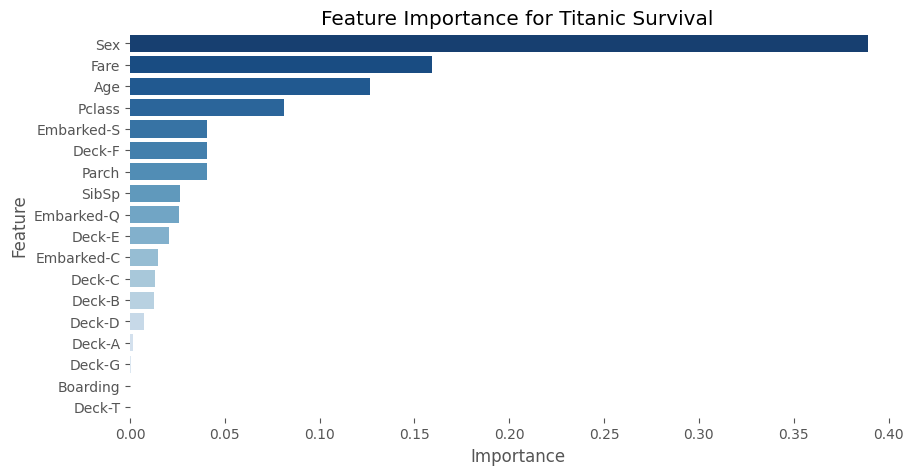

Random Forest Accuracy: 0.92


In [35]:
#Relevant features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
        'Boarding', 'Fare', 'Embarked-C',
       'Embarked-Q', 'Embarked-S', 'Deck-A', 'Deck-B', 'Deck-C', 'Deck-D',
       'Deck-E', 'Deck-F', 'Deck-G', 'Deck-T']
X = test_final[features]
y = test_final["Survived"]

# Handle missing values
X = X.fillna(X.median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RF Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='Blues_r')
plt.title('Feature Importance for Titanic Survival')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Set bg to white
plt.gca().set_facecolor('white')
# Remove borders around plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

# Evaluate
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")

In [39]:
submission = test_final[['PassengerId', 'Survived']]

#  Kaggle submission
submission.to_csv("Predictions.csv", index=False)

print("Predictions.csv saved successfully!")

Predictions.csv saved successfully!
